In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import Polygon as shp

# Read in Data

In [2]:
gdf = gpd.read_file('data/shapefiles/MAMMALS_TERRESTRIAL_ONLY')

df = pd.read_csv('data/observations.csv')

# Make Mass Table

In [3]:
df_highest_mass = df[df['body mass'].notnull()].sort_values(by = 'body mass', ascending = False)\
                    .drop_duplicates(subset = ['species'], keep = 'first')

masses = gdf[['sci_name']].drop_duplicates().merge(df_highest_mass[['species','body mass']], 
                                                   left_on = 'sci_name', right_on = 'species', how = 'left')\
                                                   .drop(columns = ['species'])

In [4]:
masses.to_csv('masses_from_ipynb.csv', index = False)

# Read in Masses

In [5]:
masses = pd.read_csv('masses.csv')

# Create new Geometries

In [7]:
gdf = gdf.merge(masses, how = 'left', on = 'sci_name').dropna(subset = 'body mass')\
    .sort_values(by = 'body mass', ascending = False)

In [23]:
for i, row in gdf.head(2).iterrows():
    print(i)

3782
3781


In [28]:
shp1.area

0.0020282179353482053

In [29]:
shp2.area

139.32198659548118

In [32]:
shp1.union(shp2).area

139.32401481341662

In [24]:
gdf

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,family,genus,category,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry,body mass
3782,181008073,Loxodonta africana,1,2,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,0.310021,0.002028,"MULTIPOLYGON (((31.76359 -26.61175, 31.76487 -...",6000.000
3781,181008073,Loxodonta africana,1,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,518.449852,139.321987,"MULTIPOLYGON (((22.97502 -34.07926, 22.97567 -...",6000.000
3780,181008073,Loxodonta africana,4,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,271.889957,69.553075,"MULTIPOLYGON (((29.23323 -21.74140, 29.26674 -...",6000.000
3779,181008073,Loxodonta africana,3,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,223.518362,58.928504,"MULTIPOLYGON (((32.47534 -20.13611, 32.48143 -...",6000.000
8078,7140,Elephas maximus,3,5,1,"IUCN/SSC AsESG, WCS, WWF",2020,"IUCN/SSC AsESG, WCS, WWF",None,None,...,ELEPHANTIDAE,Elephas,EN,false,true,false,246.534093,9.490031,"MULTIPOLYGON (((103.81783 -4.38439, 103.77385 ...",4500.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,29662,Sorex caecutiens,1,1,1,IUCN,2012,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,0.950475,0.050470,"POLYGON ((156.40591 50.64036, 156.40639 50.638...",0.010
965,41422,Sorex tundrensis,1,1,1,IUCN,2012,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,953.025010,2698.008609,"MULTIPOLYGON (((81.54186 45.11874, 81.72656 45...",0.010
2355,29667,Sorex minutus,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,1357.221893,2064.400425,"MULTIPOLYGON (((83.64068 26.61991, 83.28411 26...",0.004
2354,29667,Sorex minutus,2,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,7.927799,1.513192,"POLYGON ((75.49854 32.28351, 75.37968 32.25822...",0.004


In [35]:
import time

In [37]:
time.time()

1705288324.7526112

In [53]:
shp1.exterior.coords.tolist()

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [83]:
un = shp([(0,0),(0,1),(1,1),(1,0)]).union(shp([(0.1,0.1),(0.1,0.9),(0.9,0.9),(0.9,0.1)]))

In [84]:
un.exterior.coords.xy

(array('d', [0.0, 1.0, 1.0, 0.0, 0.0]), array('d', [1.0, 1.0, 0.0, 0.0, 1.0]))

In [68]:
sum([len(p.exterior.coords)])

shapely.geometry.polygon.Polygon

In [78]:
import shapely as sh

def get_coords_from_polygon(shape):
    coords = set()

    if isinstance(shape, sh.geometry.Polygon):
        coords.update(shape.exterior.coords[:-1])
        for linearring in shape.geoms.interiors:
            coords.update(linearring.coords[:-1])
    elif isinstance(shape, sh.geometry.MultiPolygon):
        for polygon in shape.geoms:
            coords.update(get_coords_from_polygon(polygon))

    return coords

In [79]:
shp1.geoms

In [82]:
dir(shp1)

['__and__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 '_geom',
 '_geom_prepared',
 '_ndim',
 '_repr_svg_',
 'almost_equals',
 'area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'contains_properly',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'equals_exact',
 'geom_type',
 'geometryType',
 'geoms',
 'has_z',
 'hausdorff_distance',
 'interpolate',
 'intersection',
 'intersects',
 'is_closed',
 'is_empty',
 'is_ring',
 'is_simple',
 'is_valid',
 '

In [80]:
get_coords_from_polygon(shp1)

AttributeError: 'Polygon' object has no attribute 'geoms'

In [72]:
for p in shp1:
    pass

TypeError: 'MultiPolygon' object is not iterable

In [69]:
un.exterior.coords.xy

(array('d', [0.0, 1.0, 0.8783783783783784, 0.9, 0.1, 0.0, 0.0]),
 array('d', [2.0, 1.0, 0.8783783783783784, 0.85, 0.1, 0.0, 2.0]))

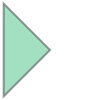

In [66]:
un

In [62]:
len(shp1.coords.xy)

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [64]:
type(shp1)

shapely.geometry.multipolygon.MultiPolygon

In [54]:
dir(shp1)

['__and__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 '_geom',
 '_geom_prepared',
 '_ndim',
 '_repr_svg_',
 'almost_equals',
 'area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'contains_properly',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'equals_exact',
 'geom_type',
 'geometryType',
 'geoms',
 'has_z',
 'hausdorff_distance',
 'interpolate',
 'intersection',
 'intersects',
 'is_closed',
 'is_empty',
 'is_ring',
 'is_simple',
 'is_valid',
 '

In [86]:
times

[1705289624.355781,
 0.026479005813598633,
 1705289624.3855479,
 0.07340812683105469,
 1705289624.430426,
 0.11262011528015137,
 1705289624.554993,
 0.4667530059814453,
 1705289624.7830768,
 0.7245833873748779,
 1705289625.0710845,
 0.9746596813201904,
 1705289625.4632561,
 1.3234028816223145,
 1705289626.0801842,
 2.0069527626037598,
 1705289626.7109272,
 2.400730848312378,
 1705289627.3732152,
 2.789341688156128,
 1705289627.3969953,
 4.087701797485352,
 1705289628.8678472,
 4.103269815444946,
 1705289630.5094671,
 5.346365928649902,
 1705289631.9702892,
 6.264864683151245]

In [90]:
df['no_overlap_geometry'] = np.nan
union = shp([])

start = time.time()
abs_times = [0]
rel_times = []
j = 0
for i, row in gdf.head(2).iterrows():
    this_geo = row['geometry']
    new_geo = this_geo - union
    gdf.loc[i, 'no_overlap_geometry'] = new_geo
    if new_geo.area > 0:
        union = this_geo.union(union)
    j += 1
    rel_times.append(time.time() - abs_times[-1] - start)
    abs_times.append(time.time()-start)
    print(j, rel_times[-1], abs_times[-1])

1 1705289928.718556 0.0033168792724609375
2 1705289928.7537653 0.04184293746948242


In [89]:
times

[1705289703.5066612, 0.022452831268310547, 1705289703.5311813]

In [ ]:
gdf['']

In [27]:
gdf.columns

Index(['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler',
       'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island',
       'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum',
       'class', 'order_', 'family', 'genus', 'category', 'marine',
       'terrestial', 'freshwater', 'Shape_Leng', 'Shape_Area', 'geometry',
       'body mass'],
      dtype='object')

In [13]:
shp1 = gdf['geometry'].values[0]
shp2 = gdf['geometry'].values[1]

In [18]:
b = shp1.union(shp2)

In [22]:
shp1.area

0.0020282179353482053

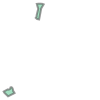

In [26]:
shp1-shp2

In [21]:
shp2.area

139.32198659548118

In [20]:
b.area

139.32401481341662

In [16]:
gdf

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,family,genus,category,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry,body mass
3782,181008073,Loxodonta africana,1,2,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,0.310021,0.002028,"MULTIPOLYGON (((31.76359 -26.61175, 31.76487 -...",6000.000
3781,181008073,Loxodonta africana,1,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,518.449852,139.321987,"MULTIPOLYGON (((22.97502 -34.07926, 22.97567 -...",6000.000
3780,181008073,Loxodonta africana,4,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,271.889957,69.553075,"MULTIPOLYGON (((29.23323 -21.74140, 29.26674 -...",6000.000
3779,181008073,Loxodonta africana,3,1,1,IUCN SSC African Elephant Specialist Group,2021,IUCN SSC African Elephant Specialist Group,None,None,...,ELEPHANTIDAE,Loxodonta,EN,false,true,false,223.518362,58.928504,"MULTIPOLYGON (((32.47534 -20.13611, 32.48143 -...",6000.000
8078,7140,Elephas maximus,3,5,1,"IUCN/SSC AsESG, WCS, WWF",2020,"IUCN/SSC AsESG, WCS, WWF",None,None,...,ELEPHANTIDAE,Elephas,EN,false,true,false,246.534093,9.490031,"MULTIPOLYGON (((103.81783 -4.38439, 103.77385 ...",4500.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3563,29662,Sorex caecutiens,1,1,1,IUCN,2012,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,0.950475,0.050470,"POLYGON ((156.40591 50.64036, 156.40639 50.638...",0.010
965,41422,Sorex tundrensis,1,1,1,IUCN,2012,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,953.025010,2698.008609,"MULTIPOLYGON (((81.54186 45.11874, 81.72656 45...",0.010
2355,29667,Sorex minutus,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,1357.221893,2064.400425,"MULTIPOLYGON (((83.64068 26.61991, 83.28411 26...",0.004
2354,29667,Sorex minutus,2,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,None,None,...,SORICIDAE,Sorex,LC,false,true,false,7.927799,1.513192,"POLYGON ((75.49854 32.28351, 75.37968 32.25822...",0.004


In [12]:
union

In [ ]:
for 

In [ ]:
gdf['no_overlap_geometry'] = np.nan

In [8]:
import shapely as shp

In [ ]:
len(gdf['sci_name'].unique())

81

In [ ]:
masses[masses['body mass'].notnull()]

,sci_name,body mass
0,Syncerus caffer,700.00
1,Tragelaphus eurycerus,350.00
2,Panthera tigris,230.00
3,Cervus canadensis,300.00
4,Gorilla gorilla,140.00
...,...,...
5255,Bos gaurus,950.00
5265,Bison bonasus,780.00
5514,Alexandromys oeconomus,0.05
5524,Alces alces,630.00


In [ ]:
len(masses)

5633

In [ ]:
len(gdf['sci_name'].unique())

5633

In [ ]:
gdf[gdf['sci_name'].str.contains('Rhinoceros')]

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,order_,family,genus,category,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry
11245,19495,Rhinoceros sondaicus,1,1,1,IUCN,2020,IUCN (International Union for Conservation of ...,None,None,...,PERISSODACTYLA,RHINOCEROTIDAE,Rhinoceros,CR,false,true,false,30.961061,10.314619,"POLYGON ((112.58089 -6.92902, 112.57632 -6.928..."


In [ ]:
masses

,sci_name,body mass
0,Paradoxurus jerdoni,NaN
1,Lophostoma occidentalis,NaN
2,Microcebus boraha,NaN
3,Pseudomys pilligaensis,NaN
4,Echiothrix leucura,NaN
...,...,...
5838,Acomys percivali,NaN
5839,Nasuella meridensis,NaN
5840,Microtus liechtensteini,NaN
5841,Euroscaptor longirostris,NaN


# Read in Shapefile as Geopandas Dataframe

In [ ]:
gdf.columns

Index(['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler',
       'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island',
       'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum',
       'class', 'order_', 'family', 'genus', 'category', 'marine',
       'terrestial', 'freshwater', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [ ]:
df2 = pd.DataFrame(gdf[['sci_name','Shape_Area']])

In [ ]:
df[['genus','species','body mass - maximum']]

,genus,species,body mass - maximum
0,Hyla,Hyla versicolor,NaN
1,Pseudacris,Pseudacris triseriata,NaN
2,Acris,Acris crepitans,NaN
3,Platymantis,Platymantis vitiensis,NaN
4,Rana,Rana sylvatica,NaN
...,...,...,...
3575,Sphaerodactylus,Sphaerodactylus cinereus,NaN
3576,Sphaerodactylus,Sphaerodactylus notatus,NaN
3577,Anolis,Anolis sagrei,NaN
3578,Coleonyx,Coleonyx switaki,NaN


In [ ]:
df.columns

Index(['phylum', 'class', 'order', 'family', 'genus', 'species',
       'specificEpithet', 'sex', 'sampleSizeValue', 'inTextReference',
       'publicationYear', 'fullReference', 'body mass', 'body mass - units',
       'body mass - minimum', 'body mass - maximum', 'body mass - method',
       'body mass - comments', 'body mass - metadata comment',
       'original body mass', 'original body mass - units', 'metabolic rate',
       'metabolic rate - units', 'metabolic rate - minimum',
       'metabolic rate - maximum', 'metabolic rate - method',
       'metabolic rate - comments', 'metabolic rate - metadata comment',
       'original metabolic rate', 'original metabolic rate - units',
       'original respiratoryQuotient', 'original temperature',
       'mass-specific metabolic rate', 'mass-specific metabolic rate - units',
       'brain size', 'brain size - units', 'brain size - minimum',
       'brain size - maximum', 'brain size - method', 'brain size - comments',
       'brain size 

In [ ]:
df['body mass']

0       0.01315
1       0.00010
2       0.00030
3       0.00030
4       0.00037
         ...   
3575    0.00054
3576    0.00033
3577    0.00040
3578    0.00946
3579    0.00362
Name: body mass, Length: 3580, dtype: float64

In [ ]:
sum(df['class'] == 'Mammalia')

1020

In [ ]:
len(np.intersect1d(df['species'],gdf['sci_name']))

485

In [ ]:
gdf[gdf['sci_name'] == 'Elephas maximus']

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,order_,family,genus,category,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry
8077,7140,Elephas maximus,3,1,1,"IUCN/SSC AsESG, WCS, WWF",2020,"IUCN/SSC AsESG, WCS, WWF",None,None,...,PROBOSCIDEA,ELEPHANTIDAE,Elephas,EN,false,true,false,214.858199,22.409475,"MULTIPOLYGON (((101.47874 -2.50466, 101.50390 ..."
8078,7140,Elephas maximus,3,5,1,"IUCN/SSC AsESG, WCS, WWF",2020,"IUCN/SSC AsESG, WCS, WWF",None,None,...,PROBOSCIDEA,ELEPHANTIDAE,Elephas,EN,false,true,false,246.534093,9.490031,"MULTIPOLYGON (((103.81783 -4.38439, 103.77385 ..."
8079,7140,Elephas maximus,1,1,1,"IUCN/SSC AsESG, WCS, WWF",2020,"IUCN/SSC AsESG, WCS, WWF",None,None,...,PROBOSCIDEA,ELEPHANTIDAE,Elephas,EN,false,true,false,492.172950,45.235232,"MULTIPOLYGON (((105.86546 -4.73612, 105.86292 ..."


In [ ]:
gdf

,id_no,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,...,order_,family,genus,category,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry
0,16104,Paradoxurus jerdoni,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CARNIVORA,VIVERRIDAE,Paradoxurus,LC,false,true,false,45.734651,5.559232,"MULTIPOLYGON (((76.41078 10.61212, 76.41578 10..."
1,88149174,Lophostoma occidentalis,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CHIROPTERA,PHYLLOSTOMIDAE,Lophostoma,NT,false,true,false,40.333023,16.395889,"MULTIPOLYGON (((-80.15034 -5.44154, -80.38175 ..."
2,163314140,Microcebus boraha,1,1,1,IUCN,2020,IUCN (International Union for Conservation of ...,None,None,...,PRIMATES,CHEIROGALEIDAE,Microcebus,DD,false,true,false,1.279308,0.014417,"POLYGON ((50.01109 -16.70219, 50.01082 -16.703..."
3,18555,Pseudomys pilligaensis,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,RODENTIA,MURIDAE,Pseudomys,DD,false,true,false,3.942112,0.653697,"POLYGON ((149.84833 -30.46726, 149.84878 -30.4..."
4,7014,Echiothrix leucura,1,1,1,IUCN SSC Small Mammal Specialist Group,2016,IUCN SSC Small Mammal Specialist Group,None,None,...,RODENTIA,MURIDAE,Echiothrix,EN,false,true,false,2.918288,0.295186,"MULTIPOLYGON (((124.56080 1.18754, 124.55930 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12485,17314,Pipistrellus kuhlii,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CHIROPTERA,VESPERTILIONIDAE,Pipistrellus,LC,false,true,false,3.227012,0.171977,"POLYGON ((26.35545 39.37919, 26.35545 39.37919..."
12486,17314,Pipistrellus kuhlii,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CHIROPTERA,VESPERTILIONIDAE,Pipistrellus,LC,false,true,false,4.078058,0.380030,"POLYGON ((3.20288 39.95265, 3.20123 39.94886, ..."
12487,17314,Pipistrellus kuhlii,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CHIROPTERA,VESPERTILIONIDAE,Pipistrellus,LC,false,true,false,791.487781,1093.063374,"MULTIPOLYGON (((-14.05650 25.93354, -14.07125 ..."
12488,17314,Pipistrellus kuhlii,6,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,...,CHIROPTERA,VESPERTILIONIDAE,Pipistrellus,LC,false,true,false,13.467769,3.066149,"POLYGON ((34.86919 45.96458, 34.87545 45.94761..."


In [ ]:
df['original body mass - units'].unique()

array(['g', nan, 'mg', 'kg', 'ug'], dtype=object)

In [ ]:
len(df[df['class'] == 'Mammalia'])

1020

In [ ]:
gdf.columns

Index(['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler',
       'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island',
       'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum',
       'class', 'order_', 'family', 'genus', 'category', 'marine',
       'terrestial', 'freshwater', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [ ]:
type(gdf['geometry'].loc[0])

shapely.geometry.multipolygon.MultiPolygon

In [ ]:
len(gdf)

12490